In [1]:
import pickle
import numpy as np
import torch
from tqdm import tqdm
import numqi
import matplotlib.pyplot as plt

In [2]:
# Random generate a d^-1-dimensional real vector in Euclidean space
def random_vector(d):
    x = np.random.normal(size=d*d-1)
    x = x / np.linalg.norm(x)
    return x

def save_data(xdata, ydata, filepath='data_boundary.pkl'):
    with open(filepath, 'wb') as fid:
        pickle.dump(dict(xdata=xdata, ydata=ydata), fid)

def load_data(filepath='data_boundary.pkl'):
    with open(filepath, 'rb') as fid:
        tmp0 = pickle.load(fid)
        ret = tmp0['xdata'], tmp0['ydata']
    return ret


In [13]:
dimA = 3
dimB = 3 
dim = dimA * dimB
num_sample_random_mixed = 5000000
num_sample_random_pure = int(num_sample_random_mixed // 2)
num_sample = num_sample_random_mixed + num_sample_random_pure
batch_size = 128

In [14]:
# Training data
xdata = []
ydata = []
vec_list = [random_vector(dim) for _ in range(num_sample_random_mixed//2)]
for vec in tqdm(vec_list):
    rho = numqi.gellmann.gellmann_basis_to_dm(vec)
    beta_ppt_l, beta_ppt_u = numqi.entangle.get_ppt_boundary(rho,(dimA,dimB))
    xdata.append(vec)
    ydata.append(beta_ppt_u)
    xdata.append(-vec)
    ydata.append(-beta_ppt_l)
xdata = np.array(xdata)
ydata = np.array(ydata)
print(f'Mixed ppt state: min: {np.min(ydata)}, max: {np.max(ydata)}, mean: {np.mean(ydata)}, variance: {np.var(ydata)}')
save_data(xdata, ydata, f'data_ppt_mixed_boundary_{dimA}*{dimB}_{num_sample_random_mixed}.pkl') 

xdata = []
ydata = []
pure_state_list = [numqi.random.rand_bipartite_state(dimA, dimB) for _ in range(num_sample_random_pure)]
for state in tqdm(pure_state_list):
    rho = state[:, np.newaxis] @ state[np.newaxis, :].conj()
    _, beta_ppt_u = numqi.entangle.get_ppt_boundary(rho,(dimA,dimB))
    vec = numqi.gellmann.dm_to_gellmann_basis(rho)
    xdata.append(vec)
    ydata.append(beta_ppt_u)
xdata = np.array(xdata)
ydata = np.array(ydata)
print(f'Pure ppt state: min: {np.min(ydata)}, max: {np.max(ydata)}, mean: {np.mean(ydata)}, variance: {np.var(ydata)}')
save_data(xdata, ydata, f'data_ppt_pure_boundary_{dimA}*{dimB}_{num_sample_random_pure}.pkl') 

100%|██████████| 2500000/2500000 [02:48<00:00, 14812.87it/s]


Mixed ppt state: min: 0.10248312404630892, max: 0.19699880488163862, mean: 0.14245249689242884, variance: 9.856548517168222e-05


100%|██████████| 2500000/2500000 [02:29<00:00, 16688.13it/s]


Pure ppt state: min: 0.12124211970767142, max: 0.4126857371557054, mean: 0.14586559821194295, variance: 0.0003140996121175323


In [15]:
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()
        tmp0 = [dim**2-1, 128, 256, 256, 512, 512, 512, 256, 256, 128, 1]
        self.fc_list = torch.nn.ModuleList([torch.nn.Linear(tmp0[x], tmp0[x+1]) for x in range(len(tmp0)-1)])
        self.bn_list = torch.nn.ModuleList([torch.nn.BatchNorm1d(tmp0[x+1]) for x in range(len(tmp0)-1)])
        self.a = torch.sqrt(torch.tensor(1/(2*dim*(dim-1)), dtype=torch.float32))
        self.b = torch.sqrt(torch.tensor((dim-1)/(2*dim), dtype=torch.float32))
        self.scale = torch.tensor(0.05, dtype=torch.float32)

    def forward(self, x):
        for ind0 in range(len(self.fc_list)):
            y = self.fc_list[ind0](x)
            y = self.bn_list[ind0](y)
            if ind0<(len(self.fc_list)-1):
                y = torch.nn.functional.leaky_relu(y)
            if x.shape[-1]==y.shape[-1]:
                x = y + x
            else:
                x = y
        x = (1 + self.scale) * (self.b - self.a) * torch.sigmoid(x) + self.a * (1 - self.scale)
        x = x[:,0] 
        return x

In [16]:
xdata_mixed,ydata_mixed = load_data(filepath=f'data_ppt_mixed_boundary_{dimA}*{dimB}_{num_sample_random_mixed}.pkl')
xdata_pure,ydata_pure = load_data(filepath=f'data_ppt_pure_boundary_{dimA}*{dimB}_{num_sample_random_pure}.pkl')
xdata = np.concatenate([xdata_mixed, xdata_pure], axis=0)
ydata = np.concatenate([ydata_mixed, ydata_pure], axis=0)
tmp0 = torch.tensor(xdata, dtype=torch.float32)
tmp1 = torch.tensor(ydata, dtype=torch.float32)
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tmp0, tmp1), batch_size=batch_size, shuffle=True)

In [17]:
model = Net(dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_history = []
model.train()
for epoch in range(1):
    with tqdm(dataloader) as pbar:
        for x, y in pbar:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = torch.nn.functional.mse_loss(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            pbar.set_postfix(train_loss='{:.5}'.format(sum(loss_history[-10:])/10))

100%|██████████| 58594/58594 [15:39<00:00, 62.37it/s, train_loss=9.1663e-05]


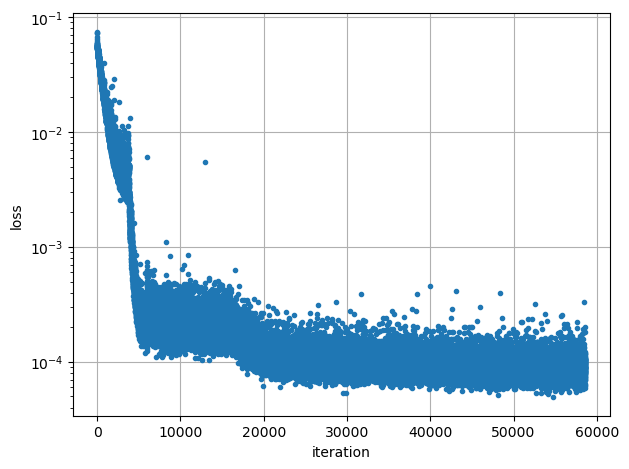

In [20]:
fig,ax = plt.subplots()
ax.plot(np.arange(len(loss_history)), loss_history, '.')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
# log scale
ax.set_yscale('log')
ax.grid()
fig.tight_layout()

In [19]:
torch.save(model, f'model_ppt_{dimA}*{dimB}_{num_sample}_{batch_size}.pt')

Text(0, 0.5, '$\\lambda_{80}$')

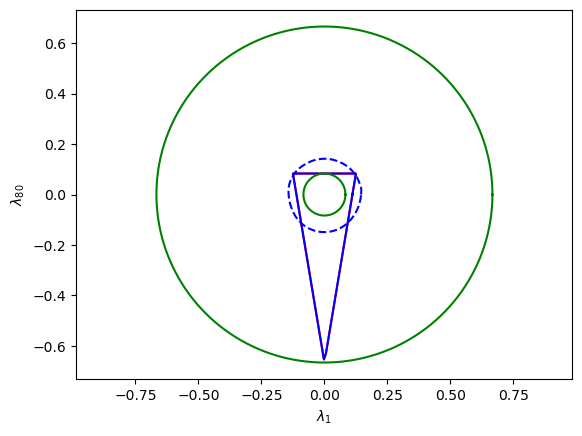

In [24]:
i=0
j=79
GellMann = numqi.gellmann.all_gellmann_matrix(dim, with_I=False)
op0 = GellMann[i] 
op1 = GellMann[j] 

theta_list = np.linspace(0, 2*np.pi, 500)
direction = np.stack([np.cos(theta_list), np.sin(theta_list)], axis=1)

_, hf_plane = numqi.entangle.get_density_matrix_plane(op0, op1)
beta_ppt_cs = np.array([numqi.entangle.get_ppt_boundary(hf_plane(x), (dimA,dimB))[1] for x in theta_list])
nr_ppt_cs = beta_ppt_cs.reshape(-1,1) * direction

beta_dm_cs = np.array([numqi.entangle.get_density_matrix_boundary(hf_plane(x))[1] for x in theta_list])
nr_dm_cs = beta_dm_cs.reshape(-1,1) * direction

vec_list = np.array([numqi.gellmann.dm_to_gellmann_basis(hf_plane(x)) for x in theta_list]).reshape(-1, dim**2-1)
model = torch.load(f'model_ppt_{dimA}*{dimB}_{num_sample}_{batch_size}.pt')
model.eval()
with torch.no_grad():
    beta_ppt_model = model(torch.tensor(vec_list, dtype=torch.float32)).numpy()

nr_ppt_model_cs = beta_ppt_model.reshape(-1,1) * direction

nr_dm_inside_ball = model.a.numpy() * direction
nr_dm_outside_ball = model.b.numpy() * direction

fig, ax = plt.subplots()
ax.plot(nr_dm_cs[:,0], nr_dm_cs[:,1], '-', color='red')
ax.plot(nr_ppt_cs[:,0], nr_ppt_cs[:,1], '-', color='blue')
ax.plot(nr_ppt_model_cs[:,0], nr_ppt_model_cs[:,1], '--', color='blue')
ax.plot(nr_dm_inside_ball[:,0], nr_dm_inside_ball[:,1], '-', color='green')
ax.plot(nr_dm_outside_ball[:,0], nr_dm_outside_ball[:,1], '-', color='green')
ax.axis('equal')
ax.set_xlabel(r'$\lambda_{%d}$'%(i+1))
ax.set_ylabel(r'$\lambda_{%d}$'%(j+1))
#fig.savefig(f'ppt_{dimA}*{dimB}_{i+1}_{j+1}.pdf')

In [ ]:
op0 = numqi.random.rand_density_matrix(dim)
op1 = numqi.random.rand_density_matrix(dim)

theta_list = np.linspace(0, 2*np.pi, 500)
direction = np.stack([np.cos(theta_list), np.sin(theta_list)], axis=1)

_, hf_plane = numqi.entangle.get_density_matrix_plane(op0, op1)
beta_ppt_cs = np.array([numqi.entangle.get_ppt_boundary(hf_plane(x), (dimA,dimB))[1] for x in theta_list])
nr_ppt_cs = beta_ppt_cs.reshape(-1,1) * direction

beta_dm_cs = np.array([numqi.entangle.get_density_matrix_boundary(hf_plane(x))[1] for x in theta_list])
nr_dm_cs = beta_dm_cs.reshape(-1,1) * direction

vec_list = np.array([numqi.gellmann.dm_to_gellmann_basis(hf_plane(x)) for x in theta_list]).reshape(-1, dim**2-1)
model = torch.load(f'model_ppt_{dimA}*{dimB}_{num_sample}_{batch_size}.pt')
model.eval()
with torch.no_grad():
    beta_ppt_model = model(torch.tensor(vec_list, dtype=torch.float32)).numpy()

nr_ppt_model_cs = beta_ppt_model.reshape(-1,1) * direction

nr_dm_inside_ball = model.a.numpy() * direction
nr_dm_outside_ball = model.b.numpy() * direction

fig, ax = plt.subplots()
ax.plot(nr_dm_cs[:,0], nr_dm_cs[:,1], '-', color='red')
ax.plot(nr_ppt_cs[:,0], nr_ppt_cs[:,1], '-', color='blue')
ax.plot(nr_ppt_model_cs[:,0], nr_ppt_model_cs[:,1], '--', color='blue')
ax.plot(nr_dm_inside_ball[:,0], nr_dm_inside_ball[:,1], '-', color='green')
ax.plot(nr_dm_outside_ball[:,0], nr_dm_outside_ball[:,1], '-', color='green')
ax.axis('equal')
#fig.savefig(f'ppt_{dimA}*{dimB}_random.pdf')



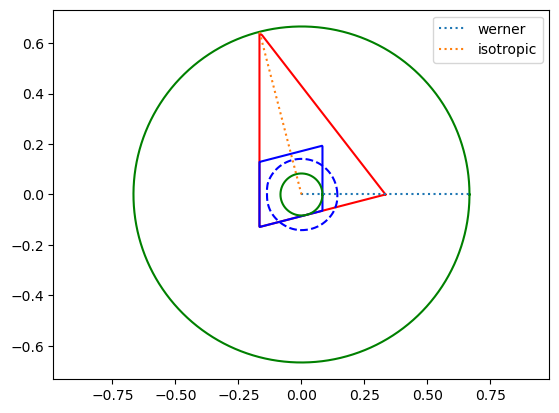

In [23]:
op0 = numqi.state.Werner(dimA, 1)
op1 = numqi.state.Isotropic(dimA, 1)

theta_list = np.linspace(0, 2*np.pi, 500)
direction = np.stack([np.cos(theta_list), np.sin(theta_list)], axis=1)

theta1, hf_plane = numqi.entangle.get_density_matrix_plane(op0, op1)
beta_ppt_cs = np.array([numqi.entangle.get_ppt_boundary(hf_plane(x), (dimA,dimB))[1] for x in theta_list])
nr_ppt_cs = beta_ppt_cs.reshape(-1,1) * direction

beta_dm_cs = np.array([numqi.entangle.get_density_matrix_boundary(hf_plane(x))[1] for x in theta_list])
nr_dm_cs = beta_dm_cs.reshape(-1,1) * direction

vec_list = np.array([numqi.gellmann.dm_to_gellmann_basis(hf_plane(x)) for x in theta_list]).reshape(-1, dim**2-1)
model = torch.load(f'model_ppt_{dimA}*{dimB}_{num_sample}_{batch_size}.pt')
model.eval()
with torch.no_grad():
    beta_ppt_model = model(torch.tensor(vec_list, dtype=torch.float32)).numpy()

nr_ppt_model_cs = beta_ppt_model.reshape(-1,1) * direction

nr_dm_inside_ball = model.a.numpy() * direction
nr_dm_outside_ball = model.b.numpy() * direction

fig, ax = plt.subplots()
ax.plot(nr_dm_cs[:,0], nr_dm_cs[:,1], '-', color='red')
ax.plot(nr_ppt_cs[:,0], nr_ppt_cs[:,1], '-', color='blue')
ax.plot(nr_ppt_model_cs[:,0], nr_ppt_model_cs[:,1], '--', color='blue')
ax.plot(nr_dm_inside_ball[:,0], nr_dm_inside_ball[:,1], '-', color='green')
ax.plot(nr_dm_outside_ball[:,0], nr_dm_outside_ball[:,1], '-', color='green')
label0 = 'werner'
label1 = 'isotropic'
for theta, label in [(0,label0),(theta1,label1)]:
    radius = model.b.numpy()
    ax.plot([0, radius*np.cos(theta)], [0, radius*np.sin(theta)], linestyle=':', label=label)
ax.axis('equal')
ax.legend()
#fig.savefig(f'ppt_{dimA}*{dimB}_{label0}_{label1}.pdf')
